## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the Dataset

In [4]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
data.shape

(5171, 4)

## Balance the Dataset

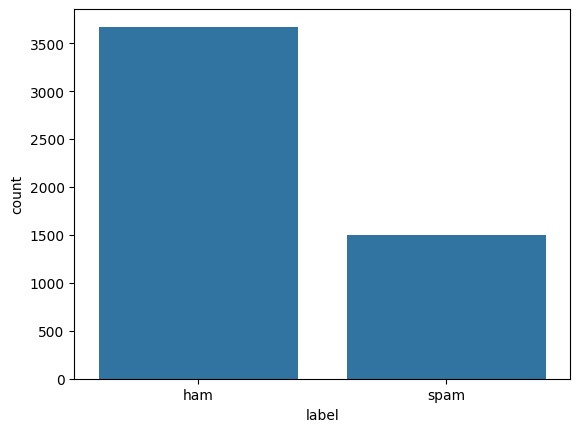

In [6]:
sns.countplot(x="label", data=data)
plt.show()

In [7]:
ham_emails = data[data["label"] == "ham"]
spam_emails = data[data["label"] == "spam"]

# Downsample Ham emails to match the number of Spam emails
ham_emails_balanced = ham_emails.sample(n=len(spam_emails), random_state=42)

# Combine balanced data
balanced_data = pd.concat([ham_emails_balanced, spam_emails]).reset_index(drop=True)

balanced_data.shape

(2998, 4)

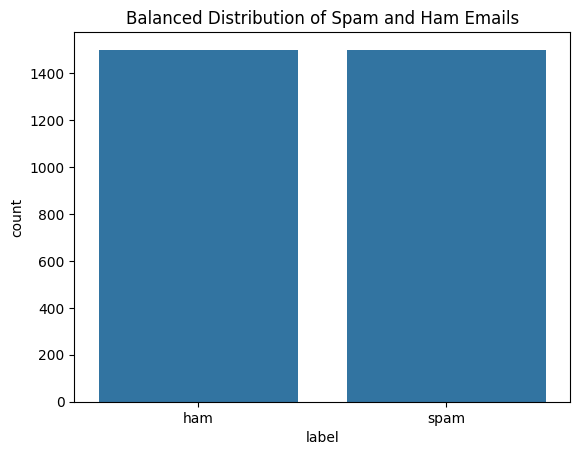

In [8]:
sns.countplot(x="label", data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.show()

## Clean the Text

In [9]:
balanced_data["text"] = balanced_data["text"].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [10]:
punctuation_list = string.punctuation

def remove_punctuations(text):
    temp = str.maketrans("", "", punctuation_list)
    return text.translate(temp)

balanced_data["text"] = balanced_data["text"].apply(remove_punctuations)
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [11]:
def remove_stopwords(text):
    stop_words = stopwords.words("english")

    important_words = []

    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            important_words.append(word)

    output = " ".join(important_words)
    return output

balanced_data['text'] = balanced_data['text'].apply(remove_stopwords)
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


## Tokenization and Padding

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data["text"], balanced_data["label"], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding="post", truncating="post")
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

y_train = (y_train == "spam").astype(int)
y_test = (y_test == "spam").astype(int)

## Define the Model

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(max_len,)),
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │     1,274,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,625 (4.88 MB)

 Trainable params: 1,278,625 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, y_train,
    validation_data=(test_sequences, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.5735 - loss: 0.6768 - val_accuracy: 0.9517 - val_loss: 0.2598 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9454 - loss: 0.2188 - val_accuracy: 0.9450 - val_loss: 0.1780 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9527 - loss: 0.1664 - val_accuracy: 0.9483 - val_loss: 0.1702 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9554 - loss: 0.1552 - val_accuracy: 0.9517 - val_loss: 0.1686 - learning_rate: 0.0010


In [22]:
test_loss, test_accuracy = model.evaluate(test_sequences, y_test)

print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9588 - loss: 0.2546
Test Loss : 0.2597756087779999
Test Accuracy : 0.9516666531562805


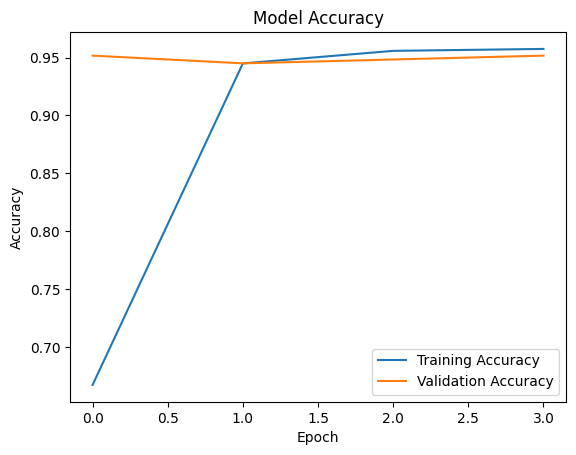

In [23]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()